<a href="https://colab.research.google.com/github/miaoshahaha/Functions/blob/main/VAE_CDF_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of VAE

In [112]:
# Import necessary libraries
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import tqdm

from torchvision.utils import save_image, make_grid
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from skimage.metrics import structural_similarity

import matplotlib.pyplot as plt
import seaborn as sns

import random


sns.set(style='dark')

#### Set the hyperparameters

In [113]:
# Set cuda
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currnet device : {DEVICE}')

# Set model hyperparameters

#batch_size = 100
x_dim = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 40



Currnet device : cpu


## Step 1. Load (or download) Dataset

In [114]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

#https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

dataset_path = '/content/'
dataset_path_idx1 = '/content/MNIST/raw/train-labels-idx1-ubyte'
dataset_path_idx3 = '/content/MNIST/raw/train-images-idx3-ubyte'

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=len(test_dataset), shuffle=False, **kwargs)




In [115]:
print(f'Number of data in training dataset : {len(train_dataset)}')
print(f'Number of data in testing dataset : {len(test_dataset)}')

Number of data in training dataset : 60000
Number of data in testing dataset : 10000


view one of the train loader data

In [116]:
image_batch, label_batch = next(iter(train_loader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([1, 28, 28]), tensor(4))

In [117]:
train_df = pd.DataFrame()
train_df

""


In [118]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

##Data Preprocessing

In [119]:
def structural_sim(img1, img2):
  sim, diff = structural_similarity(img1, img2, full=True)

  return sim, diff

In [124]:
%%time
# Create training data frame
def data_preprocess(dataset):
  df = pd.DataFrame()

  # Sum the value, which is between [0, 1], of each pixels and add additional
  # column 'weight' to the dataset.

  #for i in range(len(dataset)):
  for i in range(200):
    image = torch.flatten(dataset[i][0]).numpy()
    label = dataset[i][1]
    data = pd.DataFrame(image).T
    data['weight'] = image.sum()
    data['label'] = label
    df = pd.concat([df, data])

  # Sort the values by the 'label' column
  df = df.sort_values(by=['label'])

  # Take the first '0' image as the base to compare to other images.
  # The rest of the '0' images are also taken to compute the SSIM difference.
  first_zero_img = df.iloc[0:1, :-2].to_numpy().reshape(28, 28)
  sim, diff = structural_sim(first_zero_img, first_zero_img)
  SSIM = list()
  SSIM.append(sim)

  #for i in range(len(dataset)):
  for i in range(1, 200):
    compared_img = df.iloc[i:i+1, :-2].to_numpy().reshape(28, 28)
    sim, diff = structural_sim(first_zero_img, compared_img)
    SSIM.append(sim)

  lst = pd.DataFrame(SSIM, columns=['SSIM'])
  df = df.reset_index(drop=True)
  df = pd.concat([df, lst['SSIM']], axis=1)

  return df

data = data_preprocess(train_dataset)
data

CPU times: user 679 ms, sys: 2.02 ms, total: 681 ms
Wall time: 689 ms


,0,1,2,3,4,5,6,7,8,9,...,777,778,779,780,781,782,783,weight,label,SSIM
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,181.352936,0,1.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.407852,0,0.137037
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.164703,0,0.345853
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.850983,0,0.453754
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146.141174,0,0.448848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.200005,9,0.145127
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.658821,9,0.292475
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.560791,9,0.125015
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.764709,9,0.159011


## EDA

In [ ]:
len(data[data['label'] == 0][0])

21

In [ ]:
data.iloc[0:1, 250:280]

,250,251,252,253,254,255,256,257,258,259,...,270,271,272,273,274,275,276,277,278,279
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.984314,0.992157,0.984314,0.843137,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_0 = data[data['label'] == 0]
data_1 = data[data['label'] == 1]
data_2 = data[data['label'] == 2]
data_3 = data[data['label'] == 3]
data_4 = data[data['label'] == 4]
data_5 = data[data['label'] == 5]
data_6 = data[data['label'] == 6]
data_7 = data[data['label'] == 7]
data_8 = data[data['label'] == 8]
data_9 = data[data['label'] == 9]

print(f'Length of image 0 data : {len(data_0)}')
print(f'Length of image 1 data : {len(data_1)}')
print(f'Length of image 2 data : {len(data_2)}')
print(f'Length of image 3 data : {len(data_3)}')
print(f'Length of image 4 data : {len(data_4)}')
print(f'Length of image 5 data : {len(data_5)}')
print(f'Length of image 6 data : {len(data_6)}')
print(f'Length of image 7 data : {len(data_7)}')
print(f'Length of image 8 data : {len(data_8)}')
print(f'Length of image 9 data : {len(data_9)}')

Length of image 0 data : 21
Length of image 1 data : 26
Length of image 2 data : 20
Length of image 3 data : 21
Length of image 4 data : 21
Length of image 5 data : 13
Length of image 6 data : 19
Length of image 7 data : 21
Length of image 8 data : 15
Length of image 9 data : 23


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


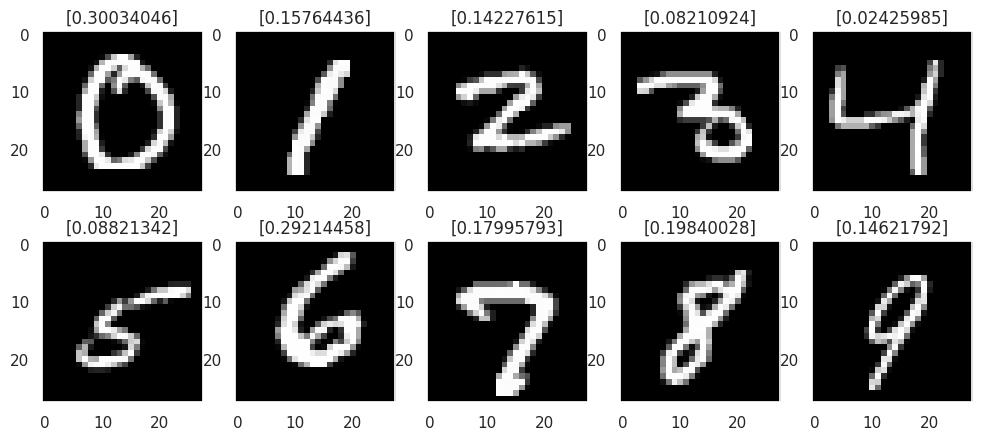

In [ ]:
def plot_SSMI_data(df):
  plt.figure(figsize=(12,5))
  for num, i in enumerate(range(1, 11)):

    img = df[df['label'] == num].iloc[10:11, :-3].to_numpy().reshape(28, 28)
    #weight = df.iloc[10:11, -3:-2].values[0]
    #label = df.iloc[10:11, -2:-1]
    ssmi = df[df['label'] == num].iloc[10:11, -1:].values[0]

    plt.subplot(2, 5, i)
    plt.imshow(img, cmap='gray')
    plt.title(ssmi)

#img = data.iloc[10:11, :-3].to_numpy().reshape(28, 28)
#plt.imshow(img)
plot_SSMI_data(data)

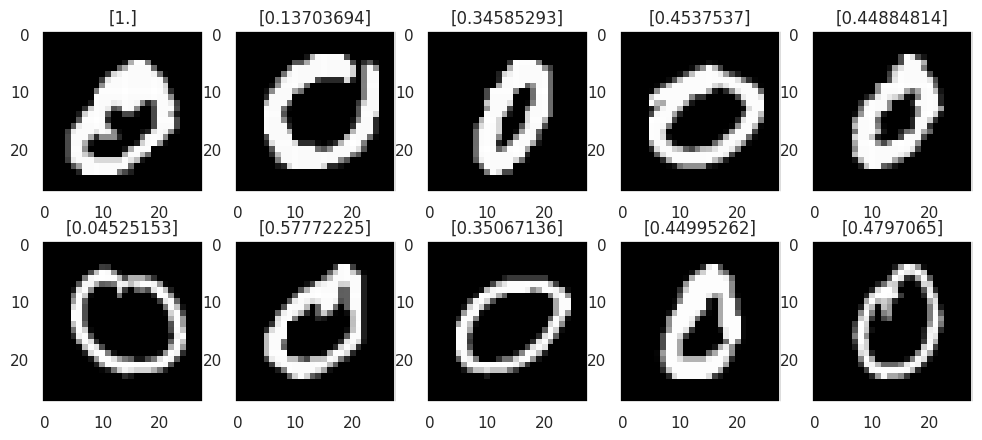

In [ ]:
def plot_SSMI_0(df):
  plt.figure(figsize=(12,5))
  for num, i in enumerate(range(1, 11)):

    img = df[df['label'] == 0].iloc[i-1:i, :-3].to_numpy().reshape(28, 28)
    #weight = df.iloc[10:11, -3:-2].values[0]
    #label = df.iloc[10:11, -2:-1]
    ssmi = df[df['label'] == 0].iloc[i-1:i, -1:].values[0]

    plt.subplot(2, 5, i)
    plt.imshow(img, cmap='gray')
    plt.title(ssmi)

#img = data.iloc[10:11, :-3].to_numpy().reshape(28, 28)
#plt.imshow(img)
plot_SSMI_0(data)

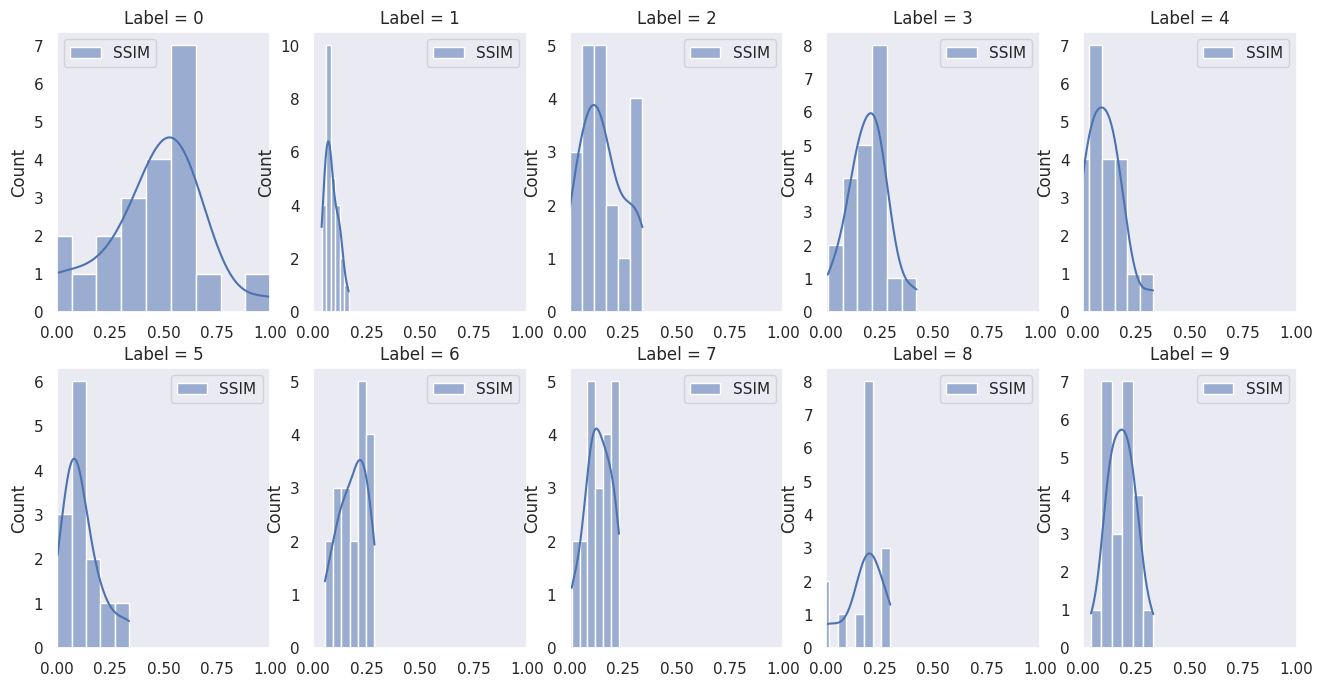

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,8))

for i in range(10):
  row = i // 5
  col = i % 5

  d = data[data['label'] == i][['SSIM']]
  sns.histplot(d, ax=axes[row, col], kde=True)

  axes[row, col].set_title(f'Label = {i}')
  axes[row, col].set_xlim(0,1)

In [ ]:
img_0 = data_0.iloc[0:1, :-3]
weight_0 = data_0.iloc[0, -3:-2].values[0]
label_0 = data_0.iloc[0, -2:-1]

img_8 = data_8.iloc[0:1, :-3]
weight_8 = data_8.iloc[0, -3:-2].values[0]
label_8 = data_8.iloc[0, -2:-1]


In [ ]:
weight_0

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_0.to_numpy().reshape(28, 28), cmap='gray')
plt.title(weight_0)

plt.subplot(1, 2, 2)
plt.imshow(img_8.to_numpy().reshape(28, 28), cmap='gray')
plt.title(weight_8)

In [ ]:
# Randomly select an image from '0'
myseed = 42
random.seed(myseed)

random_idx_0 = random.choice(range(len(data_0)))
print(random_idx_0)

# Randomly select each 'n_pic' images from '1' to '9'
n_pic = 1



# Display the selected images and weights


# Display the selected images and SSIM difference



In [ ]:
sim, diff = strutural_sim(img_0.to_numpy().reshape(28, 28), img_8.to_numpy().reshape(28, 28))

In [ ]:
sim

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,8))

for i in range(10):
  row = i // 5
  col = i % 5

  d = data[data['label'] == i][['weight']]
  sns.histplot(d, ax=axes[row, col], kde=True)

  axes[row, col].set_title(f'Label = {i}')
  axes[row, col].set_xlim(0,280)




## Training Variational AutoEncoder (VAE)


In [ ]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):

        h_       = self.LeakyReLU(self.FC_input(x))

        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):

        mean, log_var = self.Encoder(x)

        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [ ]:
image =

temp = pd.DataFrame(torch.flatten(train_dataset[0][0]).numpy()).T

temp.append(pd.DataFrame(torch.flatten(train_dataset[1][0]).numpy()).T)

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f'Label : {label.item()}')

In [ ]:
image.numpy().sum()

In [ ]:
one_data.squeeze().numpy().reshape((28, 28)).shape

In [ ]:
plt.imshow(one_data.squeeze().numpy(), cmap='gray')

In [ ]:
/content/sample_data/mnist_train_small.csv